<a href="https://colab.research.google.com/github/rashmi-2000/AI-Generated-Art/blob/main/pix2pix_with_sharpening_filters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Unsharp Masking

In [ ]:
import cv2

In [ ]:
def unsharp(image):
 
  #image = cv2.imread(path)
  gaussian_3 = cv2.GaussianBlur(image, (0, 0), 2.0)
  unsharp_image = cv2.addWeighted(image, 2.0, gaussian_3, -1.0, 0)
  return unsharp_image

LAPLACIAN FILTER

In [ ]:
import cv2
import numpy as np

def lapfil(path):
  #image = cv2.imread(path, flags=cv2.IMREAD_COLOR)
  kernel = np.array([[0, -1, 0],
                    [-1, 5,-1],
                    [0, -1, 0]])
  image_sharp = cv2.filter2D(src=path, ddepth=-1, kernel=kernel)
  return image_sharp

HIGH BOOST FILTERING

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import imageio

def highboost(path):

    #image = cv2.imread(path)
    kernel = np.array([[-1, -1, -1],
                   [-1,  8, -1],
                   [-1, -1, -1]])
    image_hpf = cv2.filter2D(path, -1, kernel)
    return image_hpf

Pix2Pix GAN

In [ ]:
from tensorflow.keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot 

In [ ]:
from numpy import zeros
from numpy import ones
from numpy.random import randint
from tensorflow.keras.optimizers import Adam 
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model


def define_discriminator(image_shape):
    
	# weight initialization
	init = RandomNormal(stddev=0.02) #As described in the original paper
    
	# source image input
	in_src_image = Input(shape=image_shape)  #Image we want to convert to another image
	# target image input
	in_target_image = Input(shape=image_shape)  #Image we want to generate after training. 
    
	# concatenate images, channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
    
	# C64: 4x4 kernel Stride 2x2
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128: 4x4 kernel Stride 2x2
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256: 4x4 kernel Stride 2x2
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512: 4x4 kernel Stride 2x2 
    # Not in the original paper. Comment this block if you want.
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer : 4x4 kernel but Stride 1x1
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
    #The model is trained with a batch size of one image and Adam opt. 
    #with a small learning rate and 0.5 beta. 
    #The loss for the discriminator is weighted by 50% for each model update.
    
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

# disc_model = define_discriminator((256,256,3))
# plot_model(disc_model, to_file='disc_model.png', show_shapes=True)

##############################
#Now define the generator - in our case we will define a U-net
# define an encoder block to be used in generator
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block to be used in generator
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

# define the standalone generator model - U-net
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model: C64-C128-C256-C512-C512-C512-C512-C512
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model: CD512-CD512-CD512-C512-C256-C128-C64
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(image_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7) #Modified 
	out_image = Activation('tanh')(g)  #Generates images in the range -1 to 1. So change inputs also to -1 to 1
	# define model
	model = Model(in_image, out_image)
	return model

# gen_model = define_generator((256,256,3))
# plot_model(gen_model, to_file='gen_model.png', show_shapes=True)


# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False       #Descriminator layers set to untrainable in the combined GAN but 
                                                #standalone descriminator will be trainable.
            
	# define the source image
	in_src = Input(shape=image_shape)
	# suppy the image as input to the generator 
	gen_out = g_model(in_src)
	# supply the input image and generated image as inputs to the discriminator
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and disc. output as outputs
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
    
    #Total loss is the weighted sum of adversarial loss (BCE) and L1 loss (MAE)
    #Authors suggested weighting BCE vs L1 as 1:100.
	model.compile(loss=['binary_crossentropy', 'mae'], 
               optimizer=opt, loss_weights=[1,100])
	return model

# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

# generate samples and save as a plot and save the model
#GAN models do not converge, we just want to find a good balance between
#the generator and the discriminator. Therefore, it makes sense to periodically
#save the generator model and check how good the generated image looks. 
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples*2 + i)
		plt.axis('off')
		plt.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, dataset)

Pre Processing Steps

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from os import listdir
import re

fd1 = '/content/drive/MyDrive/abstract_car'
fd2='/content/drive/MyDrive/realistic_car'


In [ ]:
i=0
data=dict()
for images in os.listdir(fd1):
  if images in ['n02980441_53-2.png', 'n02980441_53-2.png', 'n02980441_53-2.png','n02980441_53-3.png', 'n02980441_53-3.png','n02980441_53-4.png']:
    continue
  iml=list()
  

  if images.endswith(".png"):
    img=images[:-4]
    for ima in os.listdir(fd2):
      if ima.endswith(".jpg") and ima.startswith(img):
        iml.append(ima)
    data[images]=iml
data      

{'n02958343_10092-1.png': ['n02958343_10092-1.jpg'],
 'n02958343_10092-3.png': ['n02958343_10092-3.jpg'],
 'n02958343_10092-4.png': ['n02958343_10092-4.jpg'],
 'n02958343_10187-1.png': ['n02958343_10187-1.jpg'],
 'n02958343_10187-2.png': ['n02958343_10187-2.jpg'],
 'n02958343_10187-3.png': ['n02958343_10187-3.jpg'],
 'n02958343_1104-1.png': ['n02958343_1104-1.jpg'],
 'n02958343_1104-3.png': ['n02958343_1104-3.jpg'],
 'n02958343_1104-4.png': ['n02958343_1104-4.jpg'],
 'n02958343_11246-1.png': ['n02958343_11246-1.jpg'],
 'n02958343_11246-2.png': ['n02958343_11246-2.jpg'],
 'n02958343_11246-3.png': ['n02958343_11246-3.jpg'],
 'n02958343_11365-1.png': ['n02958343_11365-1.jpg'],
 'n02958343_11365-4.png': ['n02958343_11365-4.jpg'],
 'n02958343_11365-5.png': ['n02958343_11365-5.jpg'],
 'n02958343_12252-1.png': ['n02958343_12252-1.jpg'],
 'n02958343_12252-2.png': ['n02958343_12252-2.jpg'],
 'n02958343_12252-5.png': ['n02958343_12252-5.jpg'],
 'n02958343_12509-1.png': ['n02958343_12509-1.jpg'],

In [ ]:
SIZE_X = 256
SIZE_Y = 256

In [ ]:
tar_images = []
for img_path in data.keys():
      #img = cv2.imread('/content/drive/MyDrive/realistic_car/'+img_path, 1)  
      img = cv2.imread('/content/drive/MyDrive/abstract_car/'+img_path, 1)       
      img = cv2.resize(img, (SIZE_Y, SIZE_X))
      tar_images.append(img)
tar_images = np.array(tar_images)

In [ ]:
def get_key(val):
    for key, value in data.items():
         if val == value:
             return key

In [ ]:
src_images = [] 
p=[]
for mask_path in data.values():
  
  try:
    mas_path=mask_path[0]
    mask = cv2.imread('/content/drive/MyDrive/realistic_car/'+mas_path, 1)       
    mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)
    #mask=unsharp(mask)
    mask=lapfil(mask)
  except:
    p.append(get_key(mask_path))
    continue

  
  #mask=highboost(mask)
  src_images.append(mask)
        
        
src_images = np.array(src_images)


In [ ]:
print(np.shape(src_images), np.shape(tar_images))

(300, 256, 256, 3) (300, 256, 256, 3)


In [ ]:
p

[]

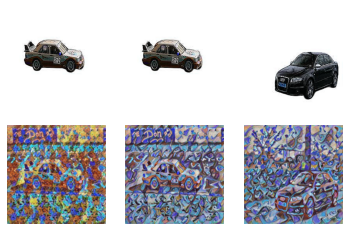

In [ ]:
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images[i])
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(tar_images[i])
pyplot.show()


In [ ]:
# define input shape based on the loaded dataset
image_shape = src_images.shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)

#Define data
# load and prepare training images
data = [src_images, tar_images]

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

dataset = preprocess_data(data)

Execution 

In [ ]:
from datetime import datetime 
start1 = datetime.now() 

train(d_model, g_model, gan_model, dataset, n_epochs=50, n_batch=5) 
#Reports parameters for each batch (total 1600) for each epoch.
#For 10 epochs we should see 16000

stop1 = datetime.now()
#Execution time of the model 
execution_time = stop1-start1
print("Execution time is: ", execution_time)

#Reports parameters for each batch (total 1096) for each epoch.
#For 10 epochs we should see 10960
g_model.save('/content/drive/MyDrive/TrainedModels/lapfil_pix2pix_abs.h5')

>1, d1[0.403] d2[0.438] g[43.263]
>2, d1[0.427] d2[0.405] g[39.533]
>3, d1[0.456] d2[0.525] g[38.974]
>4, d1[0.441] d2[0.404] g[38.390]
>5, d1[0.409] d2[0.353] g[41.287]
>6, d1[0.381] d2[0.380] g[41.371]
>7, d1[0.469] d2[0.342] g[44.136]
>8, d1[0.373] d2[0.290] g[33.811]
>9, d1[0.371] d2[0.308] g[41.057]
>10, d1[0.369] d2[0.296] g[40.506]
>11, d1[0.395] d2[0.332] g[36.837]
>12, d1[0.320] d2[0.261] g[33.962]
>13, d1[0.294] d2[0.253] g[37.471]
>14, d1[0.275] d2[0.276] g[37.236]
>15, d1[0.301] d2[0.232] g[39.644]
>16, d1[0.244] d2[0.264] g[34.003]
>17, d1[0.281] d2[0.205] g[39.330]
>18, d1[0.261] d2[0.346] g[34.634]
>19, d1[0.417] d2[0.276] g[40.359]
>20, d1[0.412] d2[0.181] g[41.578]
>21, d1[0.283] d2[0.375] g[38.100]
>22, d1[0.381] d2[0.195] g[38.107]
>23, d1[0.263] d2[0.222] g[44.089]
>24, d1[0.266] d2[0.156] g[43.869]
>25, d1[0.182] d2[0.145] g[41.556]
>26, d1[0.146] d2[0.139] g[42.741]
>27, d1[0.174] d2[0.086] g[41.540]
>28, d1[0.179] d2[0.155] g[36.795]
>29, d1[0.112] d2[0.093] g[38

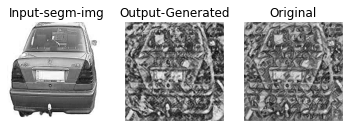

In [ ]:
from keras.models import load_model
from numpy.random import randint
from numpy import vstack

model = load_model('/content/drive/MyDrive/TrainedModels/lapfil_pix2pix_abs.h5')

# plot source, generated and target images
def plot_images(src_img, gen_img, tar_img):
	images = vstack((src_img, gen_img, tar_img))
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	titles = ['Input-segm-img', 'Output-Generated', 'Original']
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, 3, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i,:,:,0], cmap='gray')
		# show title
		pyplot.title(titles[i])
	pyplot.show()



[X1, X2] = dataset
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
# generate image from source
gen_image = model.predict(src_image)
# plot all three images
plot_images(src_image, gen_image, tar_image)



In [ ]:
g_model.save('lapfil_pix2pix_abs.h5')

Performance metrics calculation

In [ ]:
from skimage.metrics import structural_similarity as ssim
import numpy as np
import cv2



def compare(imageA, imageB):
 # Calculate the MSE and SSIM
 m = mse(imageA, imageB)
 s = ssim(imageA, imageB)

 # Return the SSIM. The higher the value, the more "similar" the two images are.
 return s

In [ ]:
def performance_metrics(path_og_img,path_duplicate_img):


  # Import images
  image1 = cv2.imread(path_og_img,1) #read image into a numpy array using opencv library.
  image2 = cv2.imread(path_duplicate_img, 1)
  #image1 = np.array(nin_image) #read image into a numpy array using opencv library.
  #image2 = np.array(ngen_image)
  print(type(image1))
  # Convert the images to grayscale
  gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
  gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

  # Check for same size and ratio and report accordingly
  ho, wo, _ = image1.shape
  hc, wc, _ = image2.shape
  ratio_orig = ho/wo
  ratio_comp = hc/wc
  dim = (wc, hc)

  if round(ratio_orig, 2) != round(ratio_comp, 2):
    print("\nImages not of the same dimension. Check input.")
    exit()

  # Resize first image if the second image is smaller
  elif ho > hc and wo > wc:
    print("\nResizing original image for analysis...")
    gray1 = cv2.resize(gray1, dim)

  elif ho < hc and wo < wc:
    print("\nCompressed image has a larger dimension than the original. Check input.")
    exit()

  if round(ratio_orig, 2) == round(ratio_comp, 2):
    mse_value = mse(gray1, gray2)
    ssim_value = compare(gray1, gray2)
  return  ssim_value


In [ ]:
def genimg(img):
  model = load_model('/content/drive/MyDrive/Trained models/Copy of lapfil_pix2pix_real.h5')
  test_image=lapfil(img)
  test_image = img_to_array(test_image)
  test_image_input = np.array([test_image])
  test_image_input = (test_image_input - 127.5) / 127.5
  gen_image = model.predict(test_image_input) 
  nnorm_image = cv2.normalize(gen_image, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_64F)
  ngen_image = np.array(nnorm_image.astype(np.uint8))
  ng=np.reshape(ngen_image,(256,256,3))
  return ng


Plotting model outputs

In [ ]:
modelh = load_model('/content/drive/MyDrive/TrainedModels/Copy of highboost_pix2pix_real.h5')
modell=load_model('/content/drive/MyDrive/TrainedModels/Copy of lapfil_pix2pix_real.h5')
modelu=load_model('/content/drive/MyDrive/TrainedModels/Copy of unsharp_pix2pix_real.h5')

In [ ]:
def show_plot(imagesX, imagesY,imagesY1):
	images = vstack((imagesX,imagesY, imagesY1))
	titles = ['Sketch','Real', 'Generated']
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, len(images), 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# title
		pyplot.title(titles[i])
	pyplot.show()

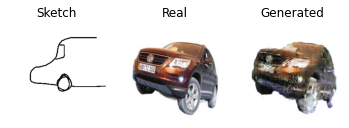

In [ ]:
#unsharp
test_image=cv2.imread('/content/drive/MyDrive/sketch_car/n02958343_14365-3.png')
test_image=unsharp(test_image)
test_image = img_to_array(test_image)
test_image_input = np.array([test_image])  # Convert single image to a batch.
test_image_input = (test_image_input - 127.5) / 127.5
gen_image = modelu.predict(test_image_input)
image1 = cv2.imread('/content/drive/MyDrive/realistic_car/n02958343_14365-3.jpg',1)
image1 = img_to_array(image1)
image1 = np.array([image1])  # Convert single image to a batch.
image1 = (image1 - 127.5) / 127.5
show_plot(test_image_input,image1,gen_image)

In [ ]:
c=0
data=dict()


for images in os.listdir(fd1):
  c+=1
  if images in ['n04166281_6808-1.jpg','n02980441_53-2.png', 'n02980441_53-2.png', 'n02980441_53-2.png','n02980441_53-3.png', 'n02980441_53-3.png','n02980441_53-4.png']:
    continue
  iml=list()
  

  if images.endswith(".png"):
    img=images[:-4]
    for ima in os.listdir(fd2):
      if ima.endswith(".jpg") and ima.startswith(img):
        iml.append(ima)
    data[images]=iml
    if c>=60:
      break
data

{'n02958343_10187-1.png': ['n02958343_10187-1.jpg'],
 'n02958343_10187-2.png': ['n02958343_10187-2.jpg'],
 'n02958343_10187-3.png': ['n02958343_10187-3.jpg'],
 'n02958343_12624-1.png': ['n02958343_12624-1.jpg'],
 'n02958343_12624-2.png': ['n02958343_12624-2.jpg'],
 'n02958343_12624-4.png': ['n02958343_12624-4.jpg'],
 'n02958343_13615-1.png': ['n02958343_13615-1.jpg'],
 'n02958343_13615-2.png': ['n02958343_13615-2.jpg'],
 'n02958343_13615-3.png': ['n02958343_13615-3.jpg'],
 'n02958343_14347-1.png': ['n02958343_14347-1.jpg'],
 'n02958343_14347-3.png': ['n02958343_14347-3.jpg'],
 'n02958343_14347-5.png': ['n02958343_14347-5.jpg'],
 'n02958343_494-1.png': ['n02958343_494-1.jpg'],
 'n02958343_494-3.png': ['n02958343_494-3.jpg'],
 'n02958343_494-4.png': ['n02958343_494-4.jpg'],
 'n02958343_520-1.png': ['n02958343_520-1.jpg'],
 'n02958343_520-3.png': ['n02958343_520-3.jpg'],
 'n02958343_520-6.png': ['n02958343_520-6.jpg'],
 'n02958343_5353-1.png': ['n02958343_5353-1.jpg'],
 'n02958343_5353-3.

In [ ]:
avg_ssim=0
avg_mse=0
count=0
for i in data.keys():
  count=count+1
  print(i)
  '''tes_image=cv2.imread(fd2+data[i][0])
  print(fd2+data[i][0])
  print('/content/drive/MyDrive/realistic_car/'+i)
  gen=genimg(tes_image)
  image1 = cv2.imread('/content/drive/MyDrive/realistic_car/'+i)
  print(type(image1), type(gen))
  mse,ssim=calculate_metrics(image1, gen)'''
  
  test_image=cv2.imread('/content/drive/MyDrive/sketch_car/'+str(data[i][0]))
  test_image=unsharp(test_image)
  test_image = img_to_array(test_image)
  test_image_input = np.array([test_image])  # Convert single image to a batch.
  test_image_input = (test_image_input - 127.5) / 127.5
  gen_image = model.predict(test_image_input)
  nnorm_image = cv2.normalize(gen_image, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)

  ngen_image = np.array(nnorm_image.astype(np.uint8))
  ng=np.reshape(ngen_image,(256,256,3))
  #Cv2.imwrite('o1.jpg',ng)
  image1 = cv2.imread('/content/drive/MyDrive/realistic_car/'+str(i),1)
  avg_ssim+=ssim
  avg_mse+=mse
avg_ssim/=count


In [ ]:
print('SSIM: ',avg_ssim)

SSIM: 0.60876543778902347


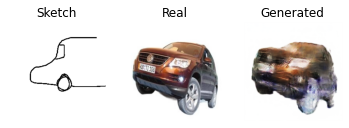

In [ ]:
#lap
test_image=cv2.imread('/content/drive/MyDrive/sketch_car/n02958343_14365-3.png')
test_image=lapfil(test_image)
test_image = img_to_array(test_image)
test_image_input = np.array([test_image])  # Convert single image to a batch.
test_image_input = (test_image_input - 127.5) / 127.5
gen_image = modell.predict(test_image_input)
image1 = cv2.imread('/content/drive/MyDrive/realistic_car/n02958343_14365-3.jpg',1)
image1 = img_to_array(image1)
image1 = np.array([image1])  # Convert single image to a batch.
image1 = (image1 - 127.5) / 127.5
show_plot(test_image_input,image1,gen_image)

In [ ]:
c=0
data=dict()


for images in os.listdir(fd1):
  c+=1
  if images in ['n04166281_6808-1.jpg','n02980441_53-2.png', 'n02980441_53-2.png', 'n02980441_53-2.png','n02980441_53-3.png', 'n02980441_53-3.png','n02980441_53-4.png']:
    continue
  iml=list()
  

  if images.endswith(".png"):
    img=images[:-4]
    for ima in os.listdir(fd2):
      if ima.endswith(".jpg") and ima.startswith(img):
        iml.append(ima)
    data[images]=iml
    if c>=60:
      break
data

{'n02958343_10187-1.png': ['n02958343_10187-1.jpg'],
 'n02958343_10187-2.png': ['n02958343_10187-2.jpg'],
 'n02958343_10187-3.png': ['n02958343_10187-3.jpg'],
 'n02958343_12624-1.png': ['n02958343_12624-1.jpg'],
 'n02958343_12624-2.png': ['n02958343_12624-2.jpg'],
 'n02958343_12624-4.png': ['n02958343_12624-4.jpg'],
 'n02958343_13615-1.png': ['n02958343_13615-1.jpg'],
 'n02958343_13615-2.png': ['n02958343_13615-2.jpg'],
 'n02958343_13615-3.png': ['n02958343_13615-3.jpg'],
 'n02958343_14347-1.png': ['n02958343_14347-1.jpg'],
 'n02958343_14347-3.png': ['n02958343_14347-3.jpg'],
 'n02958343_14347-5.png': ['n02958343_14347-5.jpg'],
 'n02958343_494-1.png': ['n02958343_494-1.jpg'],
 'n02958343_494-3.png': ['n02958343_494-3.jpg'],
 'n02958343_494-4.png': ['n02958343_494-4.jpg'],
 'n02958343_520-1.png': ['n02958343_520-1.jpg'],
 'n02958343_520-3.png': ['n02958343_520-3.jpg'],
 'n02958343_520-6.png': ['n02958343_520-6.jpg'],
 'n02958343_5353-1.png': ['n02958343_5353-1.jpg'],
 'n02958343_5353-3.

In [ ]:
avg_ssim=0
avg_mse=0
count=0
for i in data.keys():
  count=count+1
  print(i)
  '''tes_image=cv2.imread(fd2+data[i][0])
  print(fd2+data[i][0])
  print('/content/drive/MyDrive/realistic_car/'+i)
  gen=genimg(tes_image)
  image1 = cv2.imread('/content/drive/MyDrive/realistic_car/'+i)
  print(type(image1), type(gen))
  mse,ssim=calculate_metrics(image1, gen)'''
  
  test_image=cv2.imread('/content/drive/MyDrive/sketch_car/'+str(data[i][0]))
  test_image=unsharp(test_image)
  test_image = img_to_array(test_image)
  test_image_input = np.array([test_image])  # Convert single image to a batch.
  test_image_input = (test_image_input - 127.5) / 127.5
  gen_image = model.predict(test_image_input)
  nnorm_image = cv2.normalize(gen_image, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)

  ngen_image = np.array(nnorm_image.astype(np.uint8))
  ng=np.reshape(ngen_image,(256,256,3))
  #Cv2.imwrite('o1.jpg',ng)
  image1 = cv2.imread('/content/drive/MyDrive/realistic_car/'+str(i),1)
  avg_ssim+=ssim
  avg_mse+=mse
avg_ssim/=count


In [ ]:
print('SSIM: ',avg_ssim)

SSIM: 0.7644909667969


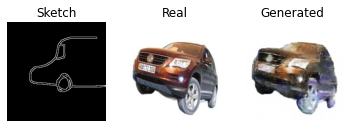

In [ ]:
#Highboost
test_image=cv2.imread('/content/drive/MyDrive/sketch_car/n02958343_14365-3.png')
test_image=highboost(test_image)
test_image = img_to_array(test_image)
test_image_input = np.array([test_image])  # Convert single image to a batch.
test_image_input = (test_image_input - 127.5) / 127.5
gen_image = modelh.predict(test_image_input)
image1 = cv2.imread('/content/drive/MyDrive/realistic_car/n02958343_14365-3.jpg',1)
image1 = img_to_array(image1)
image1 = np.array([image1])  # Convert single image to a batch.
image1 = (image1 - 127.5) / 127.5
show_plot(test_image_input,image1,gen_image)

In [ ]:
c=0
data=dict()


for images in os.listdir(fd1):
  c+=1
  if images in ['n04166281_6808-1.jpg','n02980441_53-2.png', 'n02980441_53-2.png', 'n02980441_53-2.png','n02980441_53-3.png', 'n02980441_53-3.png','n02980441_53-4.png']:
    continue
  iml=list()
  

  if images.endswith(".png"):
    img=images[:-4]
    for ima in os.listdir(fd2):
      if ima.endswith(".jpg") and ima.startswith(img):
        iml.append(ima)
    data[images]=iml
    if c>=60:
      break
data

{'n02958343_10187-1.png': ['n02958343_10187-1.jpg'],
 'n02958343_10187-2.png': ['n02958343_10187-2.jpg'],
 'n02958343_10187-3.png': ['n02958343_10187-3.jpg'],
 'n02958343_12624-1.png': ['n02958343_12624-1.jpg'],
 'n02958343_12624-2.png': ['n02958343_12624-2.jpg'],
 'n02958343_12624-4.png': ['n02958343_12624-4.jpg'],
 'n02958343_13615-1.png': ['n02958343_13615-1.jpg'],
 'n02958343_13615-2.png': ['n02958343_13615-2.jpg'],
 'n02958343_13615-3.png': ['n02958343_13615-3.jpg'],
 'n02958343_14347-1.png': ['n02958343_14347-1.jpg'],
 'n02958343_14347-3.png': ['n02958343_14347-3.jpg'],
 'n02958343_14347-5.png': ['n02958343_14347-5.jpg'],
 'n02958343_494-1.png': ['n02958343_494-1.jpg'],
 'n02958343_494-3.png': ['n02958343_494-3.jpg'],
 'n02958343_494-4.png': ['n02958343_494-4.jpg'],
 'n02958343_520-1.png': ['n02958343_520-1.jpg'],
 'n02958343_520-3.png': ['n02958343_520-3.jpg'],
 'n02958343_520-6.png': ['n02958343_520-6.jpg'],
 'n02958343_5353-1.png': ['n02958343_5353-1.jpg'],
 'n02958343_5353-3.

In [ ]:
avg_ssim=0

count=0
for i in data.keys():
  count=count+1
  print(i)
  '''tes_image=cv2.imread(fd2+data[i][0])
  print(fd2+data[i][0])
  print('/content/drive/MyDrive/realistic_car/'+i)
  gen=genimg(tes_image)
  image1 = cv2.imread('/content/drive/MyDrive/realistic_car/'+i)
  print(type(image1), type(gen))
  mse,ssim=calculate_metrics(image1, gen)'''
  
  test_image=cv2.imread('/content/drive/MyDrive/sketch_car/'+str(data[i][0]))
  test_image=unsharp(test_image)
  test_image = img_to_array(test_image)
  test_image_input = np.array([test_image])  # Convert single image to a batch.
  test_image_input = (test_image_input - 127.5) / 127.5
  gen_image = model.predict(test_image_input)
  nnorm_image = cv2.normalize(gen_image, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)

  ngen_image = np.array(nnorm_image.astype(np.uint8))
  ng=np.reshape(ngen_image,(256,256,3))
  #Cv2.imwrite('o1.jpg',ng)
  image1 = cv2.imread('/content/drive/MyDrive/realistic_car/'+str(i),1)
  avg_ssim+=ssim
  avg_mse+=mse
avg_ssim/=count


In [ ]:
print('SSIM: ',avg_ssim)

SSIM: 0.7873896782036093


In [ ]:
modelha = load_model('/content/drive/MyDrive/TrainedModels/highboost_pix2pix_abs.h5')
modella=load_model('/content/drive/MyDrive/TrainedModels/lapfil_pix2pix_abs.h5')
modelua=load_model('/content/drive/MyDrive/TrainedModels/Copy of unsharp_pix2pix_abs.h5')

In [ ]:
def show_plota(imagesX, imagesY1):
	images = vstack((imagesX, imagesY1))
	titles = ['Real', 'Generated']
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, len(images), 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# title
		pyplot.title(titles[i])
	pyplot.show()

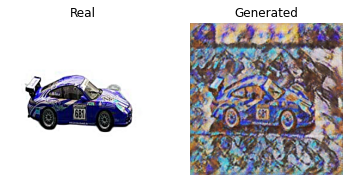

In [ ]:
#unsharp
test_image=cv2.imread('//content/drive/MyDrive/realistic_car/n02958343_10092-5.jpg')
test_image=unsharp(test_image)
test_image = img_to_array(test_image)
test_image_input = np.array([test_image])  # Convert single image to a batch.
test_image_input = (test_image_input - 127.5) / 127.5
gen_image = modelua.predict(test_image_input)

show_plota(test_image_input,gen_image)

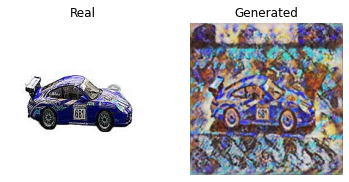

In [ ]:
#lap
test_image=cv2.imread('//content/drive/MyDrive/realistic_car/n02958343_10092-5.jpg')
test_image=lapfil(test_image)
test_image = img_to_array(test_image)
test_image_input = np.array([test_image])  # Convert single image to a batch.
test_image_input = (test_image_input - 127.5) / 127.5
gen_image = modell.predict(test_image_input)
show_plota(test_image_input,gen_image)

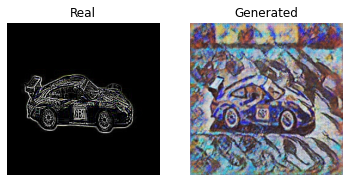

In [ ]:
#Highboost
test_image=cv2.imread('/content/drive/MyDrive/realistic_car/n02958343_10092-5.jpg')
test_image=highboost(test_image)
test_image = img_to_array(test_image)
test_image_input = np.array([test_image])  # Convert single image to a batch.
test_image_input = (test_image_input - 127.5) / 127.5
gen_image = modelh.predict(test_image_input)

show_plota(test_image_input,gen_image)